In [39]:
import pickle
import os
import numpy as np
import matplotlib.pyplot as plt

from utils.funs import scores, scores_trace 

from transformers import BeitForImageClassification, BeitForMaskedImageModeling

In [22]:
def getscores(d,l,h,dh,model):

    SList = np.zeros((l,h))
    
    # retrieve all BertLayer instances (the encoder in each layer)
    layers = model.beit.encoder.layer

    for i, layer in enumerate(layers):

        # access self-attention module within layer
        self_attention = layer.attention.attention

        # access W_q and W_k: transpose the weight matrix and split into heads
        Wq = self_attention.query._parameters["weight"].T.view(d,h,dh).detach().numpy()
        Wk = self_attention.key._parameters["weight"].T.view(d,h,dh).detach().numpy()

        for j in range(h):
            
            # compute symmetry scores
            SList[i,j] = scores_trace(Wq[:,j,:], Wk[:,j,:])

    return  SList

In [37]:
dir = '../../../_data/fig-symmetry-vision-transformers/BEiT-query-key.pkl'

if os.path.isfile(dir):
    with open(dir, 'rb') as file:
        models = pickle.load(file)
else: models = {}

In [40]:
'BEiT base (l = 12, d = 768, h = 12, patch = 16 ; 860M parameters)'
dh = 64
patch = 16
l = 12
d = 768
h = d // dh
model = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224')
sym_scores = getscores(d, l, h, dh, model)
models['BEiTbase-224'] = [l, d, h, dh, sym_scores]

'BEiT base (l = 12, d = 768, h = 12, patch = 16 ; 307M parameters)'
dh = 64
patch = 16
l = 24
d = 1024
h = d // dh
model = BeitForImageClassification.from_pretrained('microsoft/beit-large-patch16-224')
sym_scores = getscores(d, l, h, dh, model)
models['BEiTlarge-224'] = [l, d, h, dh, sym_scores]

'BEiT base (l = 12, d = 768, h = 12, patch = 16 ; 860M parameters)'
dh = 64
patch = 16
l = 12
d = 768
h = d // dh
model = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-384')
sym_scores = getscores(d, l, h, dh, model)
models['BEiTbase-384'] = [l, d, h, dh, sym_scores]

'BEiT large (l = 24, d = 1024, h = 16, patch = 16 ; 307M parameters)'
dh = 64
patch = 16
l = 24
d = 1024
h = d // dh
model = BeitForImageClassification.from_pretrained('microsoft/beit-large-patch16-384')
sym_scores = getscores(d, l, h, dh, model)
models['BEiTlarge-384'] = [l, d, h, dh, sym_scores]

'BEiT base (l = 12, d = 768, h = 12, patch = 16 ; 860M parameters)'
dh = 64
patch = 16
l = 12
d = 768
h = d // dh
model = BeitForImageClassification.from_pretrained('microsoft/beit-base-patch16-224-pt22k')
sym_scores = getscores(d, l, h, dh, model)
models['BEiTbase-224-pt22k'] = [l, d, h, dh, sym_scores]

'BEiT large (l = 24, d = 1024, h = 16, patch = 16 ; 307M parameters)'
dh = 64
patch = 16
l = 24
d = 1024
h = d // dh
model = BeitForMaskedImageModeling.from_pretrained('microsoft/beit-large-patch16-224-pt22k')
sym_scores = getscores(d, l, h, dh, model)
models['BEiTlarge-224-pt22k'] = [l, d, h, dh, sym_scores]

'save'
with open(dir, 'wb') as file:
    pickle.dump(models, file)

Some weights of BeitForImageClassification were not initialized from the model checkpoint at microsoft/beit-base-patch16-224-pt22k and are newly initialized: ['beit.pooler.layernorm.bias', 'beit.pooler.layernorm.weight', 'classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


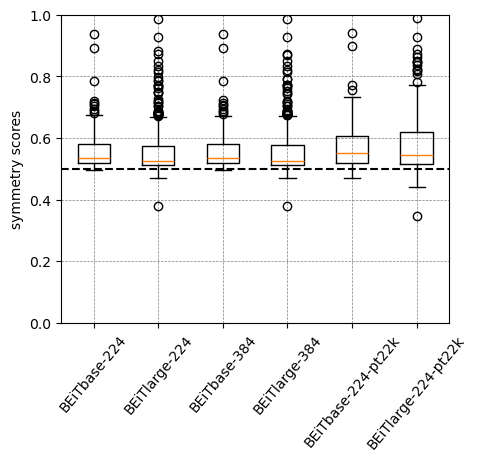

In [41]:
with open(dir, 'rb') as file:
    models = pickle.load(file)

SList = [models[key][-1].flatten() for key in list(models.keys())]
names = list(models.keys())

plt.figure(figsize=(5,4))

## BERT models
plt.boxplot(SList)

plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.ylabel('symmetry scores')
plt.xticks(np.arange(1,len(names)+1),names)
plt.xticks(rotation=50)
plt.ylim(0,1)
plt.axhline(y=.5,color='k',linestyle='dashed')